In [ ]:
# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd D:\Developments\Notebooks\cs231n\assignments\assignment1\cs231n\datasets
#!bash get_datasets.sh
%cd ../../

D:\Developments\Notebooks\cs231n\assignments\assignment1\cs231n\datasets
D:\Developments\Notebooks\cs231n\assignments\assignment1


# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [ ]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [ ]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [ ]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

In [ ]:
X_train_feats.shape

(49000, 155)

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [ ]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-1, 1e-2, 1e-3, 1e-4]
regularization_strengths = [5e-1, 5e-2, 5e-3,5e-4]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
for lr in learning_rates:
  for reg in regularization_strengths:
    model = LinearSVM()
    model.train(X_train_feats, y_train, lr, reg, 100)
    acc_train = np.mean(model.predict(X_train_feats)==y_train)
    acc_val = np.mean(model.predict(X_val_feats)==y_val)
    results[(lr, reg)] = (acc_train, acc_val)
    if acc_val>best_val:
      best_val = acc_val
      best_svm = model 


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved: %f' % best_val)

lr 1.000000e-04 reg 5.000000e-04 train accuracy: 0.395694 val accuracy: 0.404000
lr 1.000000e-04 reg 5.000000e-03 train accuracy: 0.407592 val accuracy: 0.410000
lr 1.000000e-04 reg 5.000000e-02 train accuracy: 0.400918 val accuracy: 0.383000
lr 1.000000e-04 reg 5.000000e-01 train accuracy: 0.402592 val accuracy: 0.403000
lr 1.000000e-03 reg 5.000000e-04 train accuracy: 0.433388 val accuracy: 0.431000
lr 1.000000e-03 reg 5.000000e-03 train accuracy: 0.440000 val accuracy: 0.431000
lr 1.000000e-03 reg 5.000000e-02 train accuracy: 0.435490 val accuracy: 0.432000
lr 1.000000e-03 reg 5.000000e-01 train accuracy: 0.437020 val accuracy: 0.434000
lr 1.000000e-02 reg 5.000000e-04 train accuracy: 0.488735 val accuracy: 0.482000
lr 1.000000e-02 reg 5.000000e-03 train accuracy: 0.488796 val accuracy: 0.481000
lr 1.000000e-02 reg 5.000000e-02 train accuracy: 0.487020 val accuracy: 0.481000
lr 1.000000e-02 reg 5.000000e-01 train accuracy: 0.486122 val accuracy: 0.469000
lr 1.000000e-01 reg 5.000000

In [ ]:
# Evaluate your trained SVM on the test set: you should be able to get at least 0.40
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.474


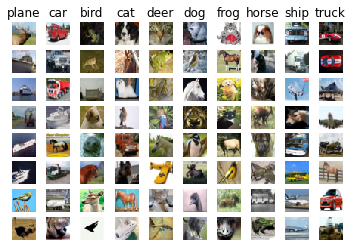

In [ ]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$ yes, seems there is an interaction between color histogram features and hog features. color histogram features might have strenghten the score of a wrong class just becasue of the clolor




## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [ ]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [ ]:
from cs231n.classifiers.fc_net import TwoLayerNet
from cs231n.solver import Solver

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

data = {
    'X_train': X_train_feats, 
    'y_train': y_train, 
    'X_val': X_val_feats, 
    'y_val': y_val, 
    'X_test': X_test_feats, 
    'y_test': y_test, 
}


best_net = None
best_acc = -1
################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
for lr in [5e-2,1e-3]:
  for reg in [5e-3, 5e-4]:
    net = TwoLayerNet(input_dim, hidden_dim, num_classes, reg=reg)
    solver = Solver(net, data, update_rule="adam", 
                    lr_decay=0.95, num_epochs=10,
                    optim_config = {"learning_rate":lr})
    solver.train()
    acc = np.mean(np.argmax(net.loss(data['X_val']), axis=1) == data['y_val'])

    if acc> best_acc:
      best_acc = acc
      best_net = net




# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


num_iterations: 4900
(Iteration 1 / 4900) loss: 2.302805
(Epoch 0 / 10) train acc: 0.114000; val_acc: 0.119000
(Iteration 11 / 4900) loss: 6.778088
(Iteration 21 / 4900) loss: 9.221302
(Iteration 31 / 4900) loss: 7.769331
(Iteration 41 / 4900) loss: 7.849924
(Iteration 51 / 4900) loss: 7.227506
(Iteration 61 / 4900) loss: 6.293588
(Iteration 71 / 4900) loss: 6.946661
(Iteration 81 / 4900) loss: 5.838009
(Iteration 91 / 4900) loss: 5.039693
(Iteration 101 / 4900) loss: 5.420194
(Iteration 111 / 4900) loss: 4.652009
(Iteration 121 / 4900) loss: 4.626416
(Iteration 131 / 4900) loss: 4.252018
(Iteration 141 / 4900) loss: 3.838145
(Iteration 151 / 4900) loss: 3.803537
(Iteration 161 / 4900) loss: 3.474805
(Iteration 171 / 4900) loss: 2.989194
(Iteration 181 / 4900) loss: 3.249094
(Iteration 191 / 4900) loss: 2.963014
(Iteration 201 / 4900) loss: 3.090665
(Iteration 211 / 4900) loss: 2.808615
(Iteration 221 / 4900) loss: 2.877383
(Iteration 231 / 4900) loss: 2.671691
(Iteration 241 / 4900) l

In [ ]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

y_test_pred = np.argmax(best_net.loss(data['X_test']), axis=1)
test_acc = (y_test_pred == data['y_test']).mean()
print(test_acc)

0.585
